In [1]:
import numpy as np
import cv2
import math
import imutils
import os
from os.path import realpath, normpath

import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster

from matplotlib import pyplot as plt

<b>Face Recognition With Haar Feature-Based Cascade Classifiers</b>

In [2]:
def getDetectedFace(frame):
    """
    frame    : the input frame in BGR color space
    """
    NUM_CLUSTERS = 5
    FaceDetected = False
    peakHSV = None
    # get xml path 
    s = realpath(cv2.__file__).split("/")[:-1]
    xmlPath = "/" + os.path.join(os.path.join(*s), "data")
    # Load the cascade classifier
    face_cascade = cv2.CascadeClassifier(os.path.join(xmlPath, 'haarcascade_frontalface_default.xml'))
    eye_cascade = cv2.CascadeClassifier(os.path.join(xmlPath, 'haarcascade_eye.xml'))
    # Convert the frame from default BGR to Gray color space
    frameGray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # Use Histogram Equalization to enhance the contrast
    frameGray = cv2.equalizeHist(frameGray)

    # detect face in current frame
    faces = face_cascade.detectMultiScale(frameGray, 1.3, 5)
    for (x,y,w,h) in faces:
        frame = cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = frameGray[y:y+h, x:x+w]
        roi_color = frame[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex,ey,ew,eh) in eyes:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
    
    if len(faces) > 0:
        FaceDetected = True
        image = frame[y:y+h, x:x+w]
        shape = image.shape
        print(shape)
        ar = image.reshape(scipy.product(shape[:2]), shape[2]).astype(float)
        codes, dist = scipy.cluster.vq.kmeans(ar, NUM_CLUSTERS)
        vecs, dist = scipy.cluster.vq.vq(ar, codes)         # assign codes
        counts, bins = scipy.histogram(vecs, len(codes))    # count occurrences
        index_max = scipy.argmax(counts)                    # find most frequent
        peak = codes[index_max]
        peak = peak.reshape(1,1,3)
        peak = peak.astype("uint8")
        peakHSV = cv2.cvtColor(peak, cv2.COLOR_BGR2HSV)

    return FaceDetected, frame, peakHSV

<b>Skin Detection using HSV boundary</b>

In [3]:
def getSkinMask(frame, lower, upper):
    """
    frame    : the input frame in BGR color space
    lower    : the lower bound for skin in HSV space
    upper    : the upper bound for skin in HSV space
    """
    # convert the frame from default BGR to HSV color space
    frameHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # apply the skin boundary to frame in HSV, get the mask for detected skin area in current frame
    skinMask = cv2.inRange(frameHSV, lower, upper)
    # apply morphological operation to the mask to remove noise
    # define the kernel for morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    # (1) use morphological opening to remove small object
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    # (2) use morphological closing to fill small holes in object
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    
    return skinMask

<b>Run Program</b>

define the lower bound and upper bound for skin detection

In [ ]:
# define the upper and lower boundaries of skin color in HSV color space
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")

Run Camera

(174, 174, 3)
(188, 188, 3)
(170, 170, 3)
(170, 170, 3)
(174, 174, 3)
(185, 185, 3)
(171, 171, 3)
(180, 180, 3)
(176, 176, 3)
(178, 178, 3)
boundary defined


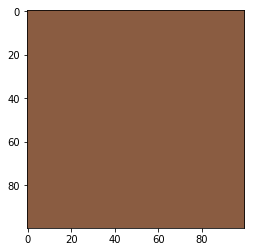

In [ ]:
# get the default camera in your system configuration
cap = cv2.VideoCapture(0)

peakHSVs = []
BoundaryDefined = False
while(True):
    # get current frame
    ret, frame = cap.read()
    # check if frame is successfully read
    if not ret:
        break
    # show the current frame
    cv2.imshow('frame',  frame)
    
    # resize the frame to decrease the computation
    frame = imutils.resize(frame, width = 500)
    
    if len(peakHSVs) < 10:
        # get face roi
        ret, faceDetected, peakHSV = getDetectedFace(frame)
        # display face roi
        cv2.imshow('faceDetected',  faceDetected)
        # put detected face to list
        if ret:
            peakHSVs.append(peakHSV)
            
    elif not BoundaryDefined:
        meanHSV = np.mean(peakHSVs, axis=0)
        meanHSV = meanHSV.astype("uint8")
        lower = meanHSV - [20, 80, 80]
        upper = meanHSV + [20, 80, 80]
        BoundaryDefined = True
        print("boundary defined")
        meanRGB = cv2.cvtColor(meanHSV, cv2.COLOR_HSV2RGB)
        blank_image = np.zeros((100,100,3), np.uint8)
        blank_image[:,:] = meanRGB
        plt.imshow(blank_image)
        plt.show()
        
    
    if BoundaryDefined:
        skinMask = getSkinMask(frame, lower, upper)
        # display skin mask
        cv2.imshow('skinMask',  skinMask)
    
    
    # exit the program when "q" key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release the camera and destroy the window when program is terminated
cap.release()
cv2.destroyAllWindows()